<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/modelos_de_difusi%C3%B3n/difusi%C3%B3n_estable_con_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Difusión Estable (*Stable Diffusion*)

Stable Diffusion es un modelo de difusión latente de texto a imagen creado por investigadores e ingenieros de [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) y [LAION](https://laion.ai/). Está entrenado en imágenes de 512x512 de un subconjunto de la base de datos [LAION-5B](https://laion.ai/blog/laion-5b/). Este modelo utiliza un codificador de texto CLIP ViT-L/14 congelado para condicionar el modelo en las indicaciones de texto. Con su codificador de texto 860M UNet y 123M, el modelo es relativamente liviano y se ejecuta en una GPU con al menos 10 GB de VRAM.
Consulte la [tarjeta del modelo](https://huggingface.co/CompVis/stable-diffusion) para obtener más información.

Este *notebook* muestra cómo usar Stable Diffusion con [Hugging Face](https://github.com/huggingface/diffusers).

## 1. Cómo utilizar `StableDiffusionPipeline`

Antes de sumergirse en los aspectos teóricos de cómo funciona la difusión estable, es recomendable primero probar cómo se puede ejecutar la inferencia de texto a imagen en solo unas pocas líneas de código.

### Configuración

Primero, validar el uso de GPU y posteriormente se debe instalar `diffusers==0.2.4` así como `scipy`, `ftfy` y `transformers`.

In [1]:
!nvidia-smi

Sun Feb 12 03:49:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


También se debe aceptar la licencia del modelo antes de descargar o usar sus parámetros. En este ejemplo se utiliza la versión del modelo `v1.4`, por lo que deberá visitar [su tarjeta](https://huggingface.co/CompVis/stable-diffusion-v1-4), leer la licencia y marcar la casilla de verificación si se está de acuerdo.

**Importante**: Se debe ser un usuario registrado en *Hugging Face Hub*, y también se necesitará usar un token de acceso para que el código funcione. Para obtener más información sobre los tokens de acceso, consultar la [documentación](https://huggingface.co/docs/hub/security-tokens).

Como google colab ha deshabilitado los *widgets* externos, éstos deben ser habilitados explícitamente para poder iniciar sesión con el token de usuario.

In [3]:
#from google.colab import output
#output.enable_custom_widget_manager()

In [4]:
#from huggingface_hub import notebook_login
#notebook_login()

### Tubería de difusión estable

`StableDiffusionPipeline` es una tubería de inferencia de extremo a extremo que puede se usada para generar imágenes a partir de texto con solo unas pocas líneas de código.

En primer lugar, se cargan los pesos preentrenados de todos los componentes del modelo.

In [5]:
import torch
from diffusers import StableDiffusionPipeline

In [7]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

El parámetro `use_auth_token` es necesario para verificar que efectivamente ha aceptado la licencia del modelo.

Se cargan los pesos de la rama de precisión media [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) y los pesos con precisión float16 pasando `torch_dtype=torch.float16`.

Si se desea garantizar la mayor precisión posible, se debe eliminar `revision="fp16"` y `torch_dtype=torch.float16` a costa de un mayor uso de memoria.

In [8]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Se mueve la canalización (pipeline) a la GPU para obtener una inferencia acelerada.

In [9]:
pipe = pipe.to("cuda")

El uso de `autocast` ejecutará la inferencia más rápido porque usa la mitad de precisión.

In [10]:
from torch import autocast

In [11]:
prompt = "baby dragon, depth of field,32k, natural light, ray tracing, ray tracing ambient light occlusion, anti-aliasing, elegant, hyper-realistic, super-detailed"

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 13.2 s, sys: 888 ms, total: 14 s
Wall time: 19.4 s


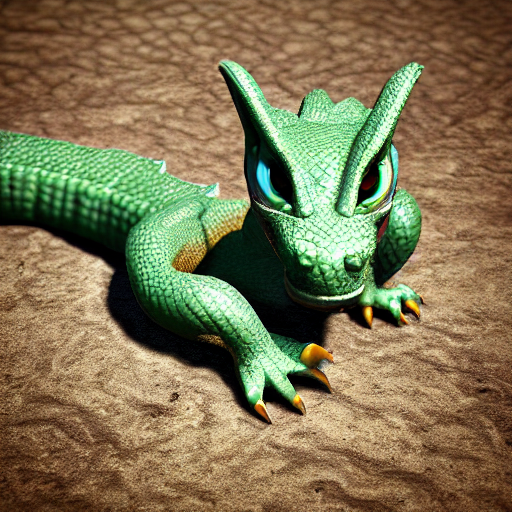

In [12]:
%%time
with autocast("cuda"):
    image = pipe(prompt).images[0]

image

Ejecutar la celda anterior varias veces dará una imagen diferente cada vez. Si se desea una salida determinista, se puede definir una semilla aleatoria dentro de la canalización. Cada vez que use la misma semilla se tendrá el mismo resultado generado.

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 11.9 s, sys: 702 ms, total: 12.6 s
Wall time: 12.9 s


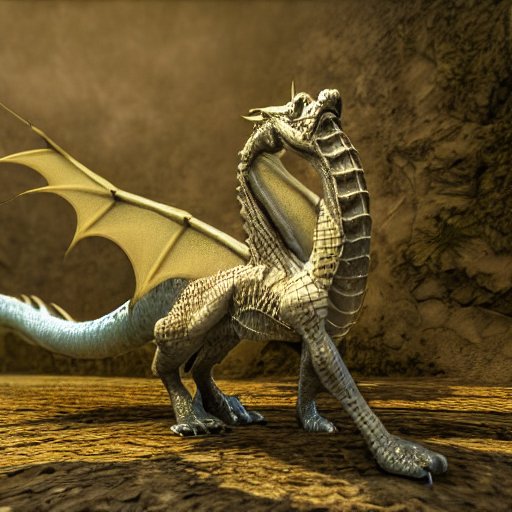

In [13]:
%%time
with autocast("cuda"):
    generator = torch.Generator("cuda").manual_seed(42)
    image = pipe(prompt, generator=generator).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 12 s, sys: 788 ms, total: 12.8 s
Wall time: 13 s


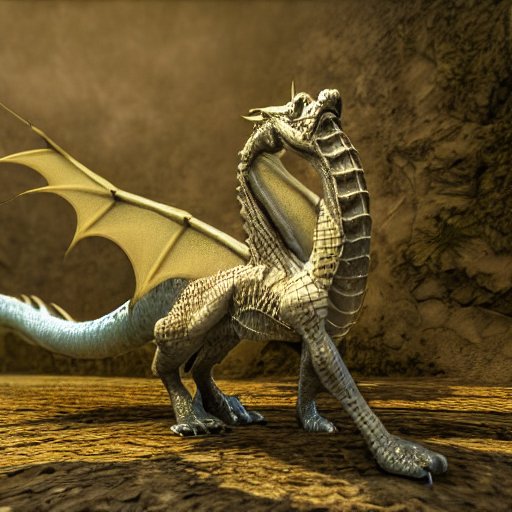

In [14]:
%%time
with autocast("cuda"):
    generator = torch.Generator("cuda").manual_seed(42)
    image = pipe(prompt, generator=generator).images[0]

image

Es posible cambiar el número de pasos de inferencia usando el argumento `num_inference_steps`. En general, los resultados son mejores cuantos más pasos son utilizados. Es recomendable utilizar el valor predeterminado de '50'. Si se desea obtener resultados más rápidos, se puede utilizar un número menor. Por el contrario, si se desea mayor calidad, es recomendable incrementar su valor.

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 4.93 s, total: 1min 15s
Wall time: 1min 16s


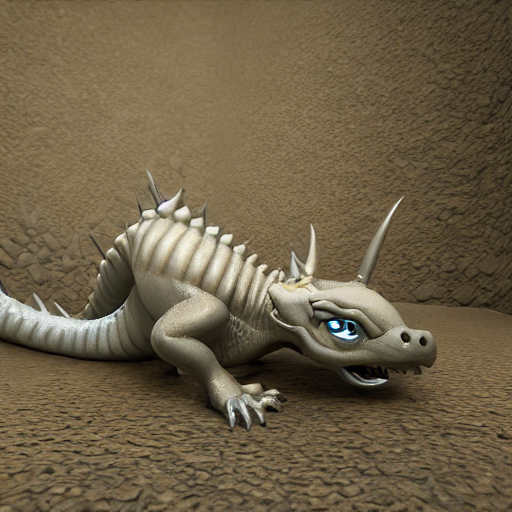

In [15]:
%%time
with autocast("cuda"):
    generator = torch.Generator("cuda").manual_seed(42)
    image = pipe(prompt, num_inference_steps=300, generator=generator).images[0]

image

In [16]:
# Guardar una imagen generada
image.save("imagen_generada.png")

**Referencias**

* https://github.com/huggingface/diffusers/tree/main/src/diffusers/pipelines